# Build linear regression models to predict chronological age

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from pathlib import Path
from toolz import concat, partial
from aging.plotting import format_plots, figure, legend, add_identity

# sklearn imports
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer, FunctionTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneGroupOut, GroupKFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from scipy.spatial.distance import pdist, squareform

In [6]:
dotted_identity = partial(add_identity, linestyle='--', color='k')
format_plots()

In [3]:
version = 7
path = Path(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_clean_pseudotime_v02.parquet"
)

df = pd.read_parquet(path)
df.set_index(
    ["pseudotime_rank", "pseudotime_dist", "pseudo_age"], append=True, inplace=True
)
df.columns = df.columns.map(int)

test_path = path.parent / "longtogeny_males_clean_v2.parquet"
test_df = pd.read_parquet(test_path).reindex(columns=df.columns).fillna(0)

In [4]:
y = df.index.get_level_values('age').values
x = df

In [15]:
keep_syll = x.mean() > 0.005
keep_syll = keep_syll[keep_syll].index

In [21]:
pipeline = make_pipeline(StandardScaler(), PLSRegression(n_components=5))
preds = cross_val_predict(pipeline, x[keep_syll], y, cv=LeaveOneGroupOut(), groups=y, n_jobs=-1)
r2 = r2_score(y, preds)
r2

0.7476862370356443

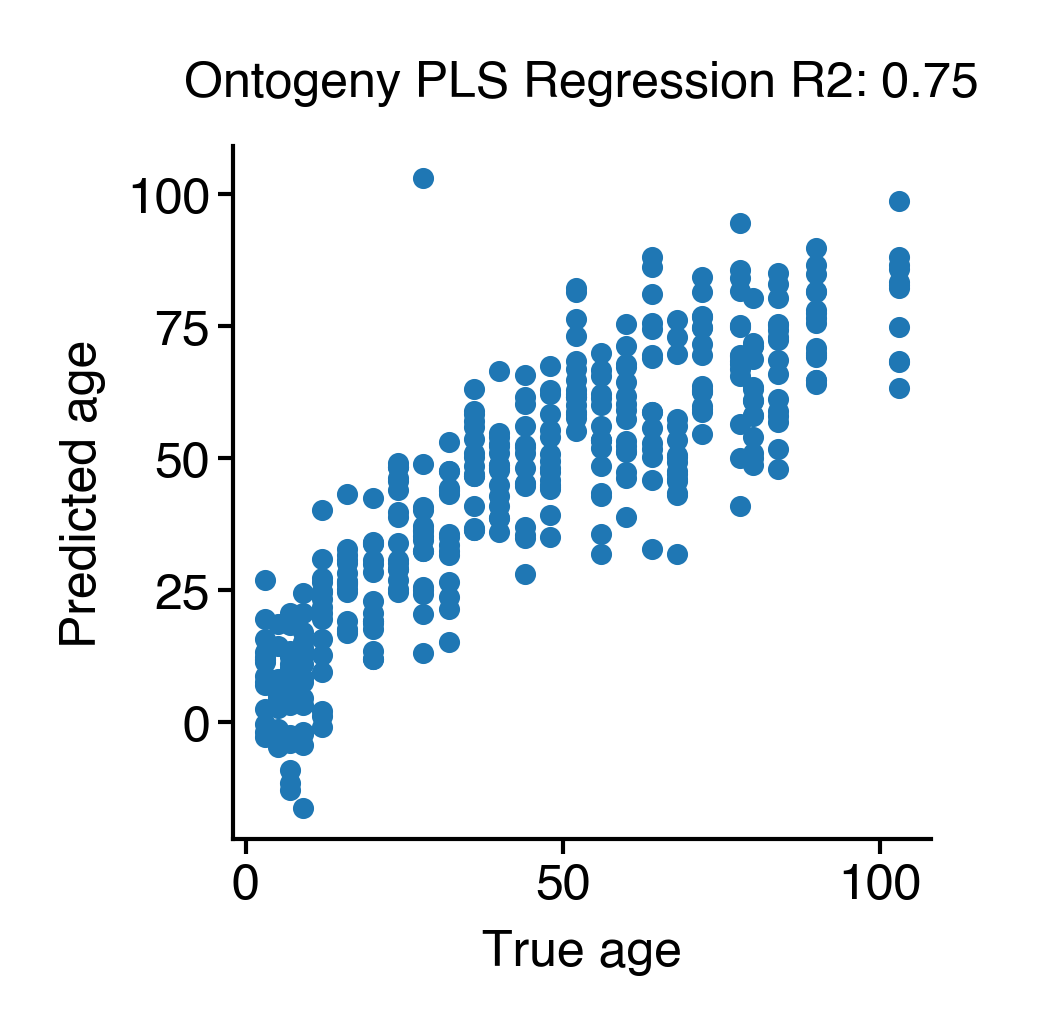

In [17]:
fig = figure(1.5, 1.5)
ax = fig.gca()
ax.scatter(y, preds, s=3)
ax.set(xlabel="True age", ylabel="Predicted age", title=f"Ontogeny PLS Regression R2: {r2:0.2f}")
sns.despine()

In [22]:
test_age = test_df.index.get_level_values("age") / 7
test_pred = pipeline.fit(x[keep_syll], y).predict(test_df[keep_syll])
r2 = r2_score(test_age, test_pred)
new_plt_df = pd.DataFrame({"age": test_age, "pred": test_pred, "mouse": test_df.index.get_level_values("mouse")})

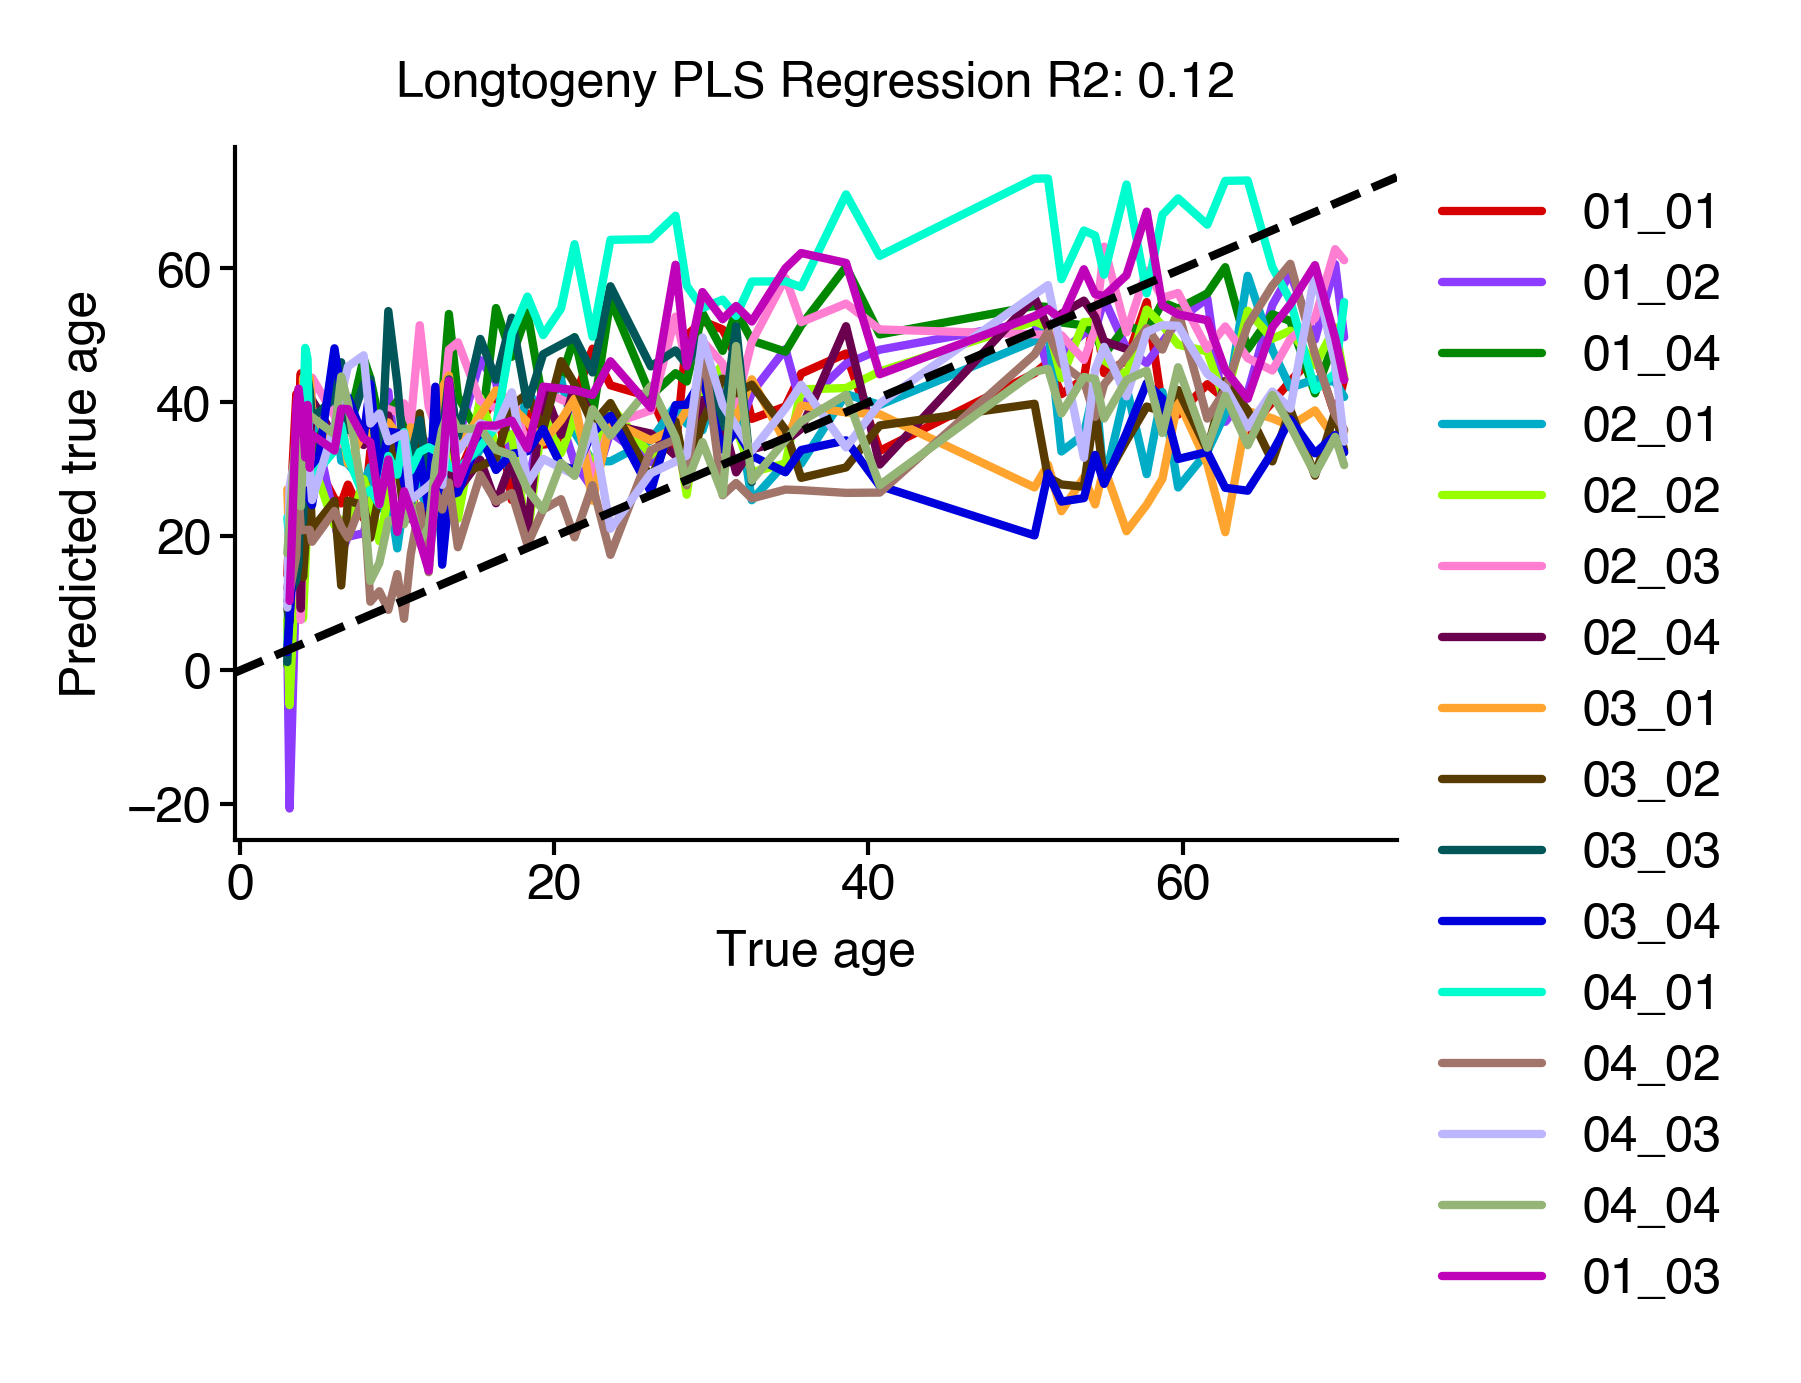

In [24]:
fig = figure(2.5, 1.5)
ax = fig.gca()
ax = sns.lineplot(
    data=new_plt_df,
    x="age",
    y="pred",
    hue="mouse",
    lw=1,
    ax=ax,
    palette=cc.glasbey[: new_plt_df["mouse"].nunique()],
)
ax.set(
    xlabel="True age",
    ylabel="Predicted true age",
    title=f"Longtogeny PLS Regression R2: {r2:0.2f}",
)
dotted_identity(ax)
legend(ax)
sns.despine()

## Fit to longtogeny, predict on ontogeny

In [36]:
pipeline = make_pipeline(StandardScaler(), PLSRegression(n_components=5))
test_age = test_df.index.get_level_values("age") / 7
bins = pd.qcut(test_age, 25, labels=False)
preds = cross_val_predict(pipeline, test_df[keep_syll], test_age, cv=LeaveOneGroupOut(), groups=bins, n_jobs=-1)
r2 = r2_score(test_age, preds)
r2

0.784924128625758

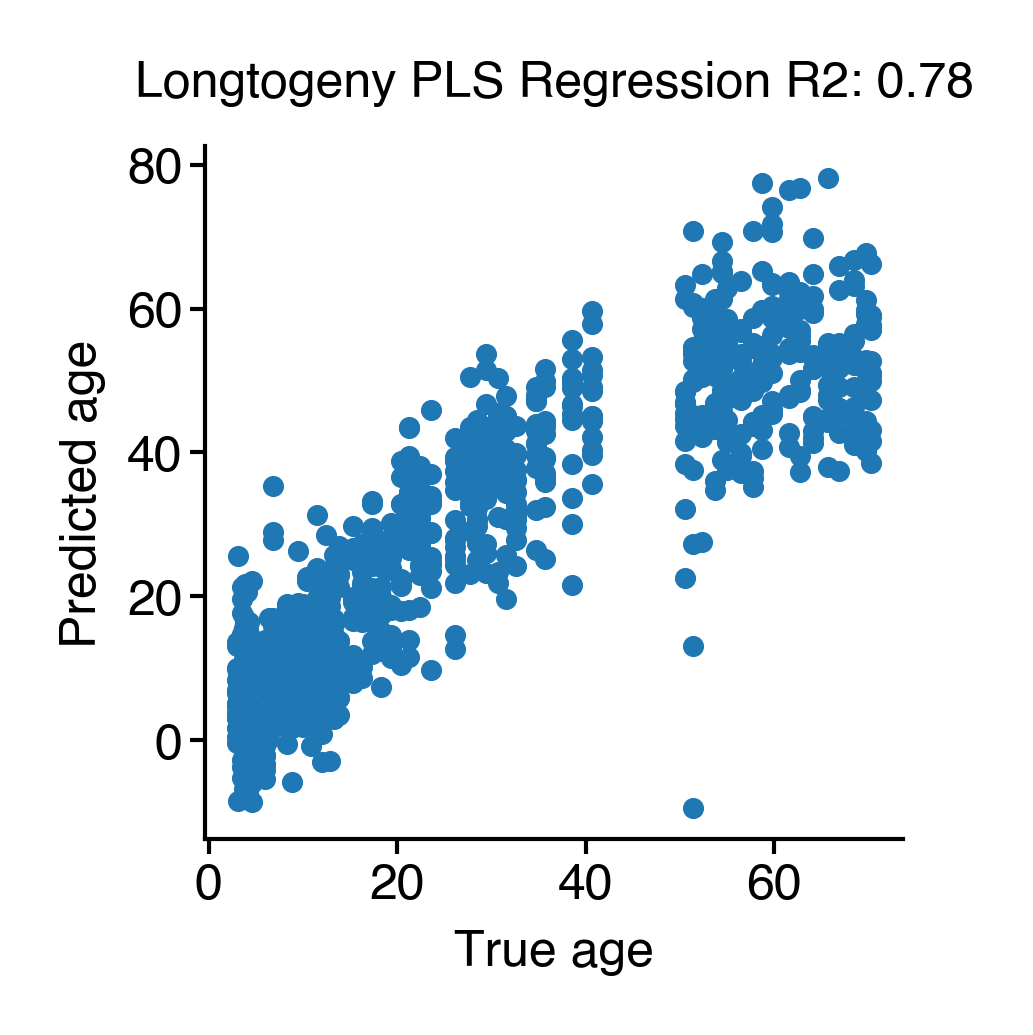

In [38]:
fig = figure(1.5, 1.5)
ax = fig.gca()
ax.scatter(test_age, preds, s=3)
ax.set(
    xlabel="True age",
    ylabel="Predicted age",
    title=f"Longtogeny PLS Regression R2: {r2:0.2f}",
)
sns.despine()

In [39]:
test_pred = pipeline.fit(test_df[keep_syll], test_age).predict(df[keep_syll])
r2 = r2_score(y, test_pred)
new_plt_df = pd.DataFrame({"age": y, "pred": test_pred})

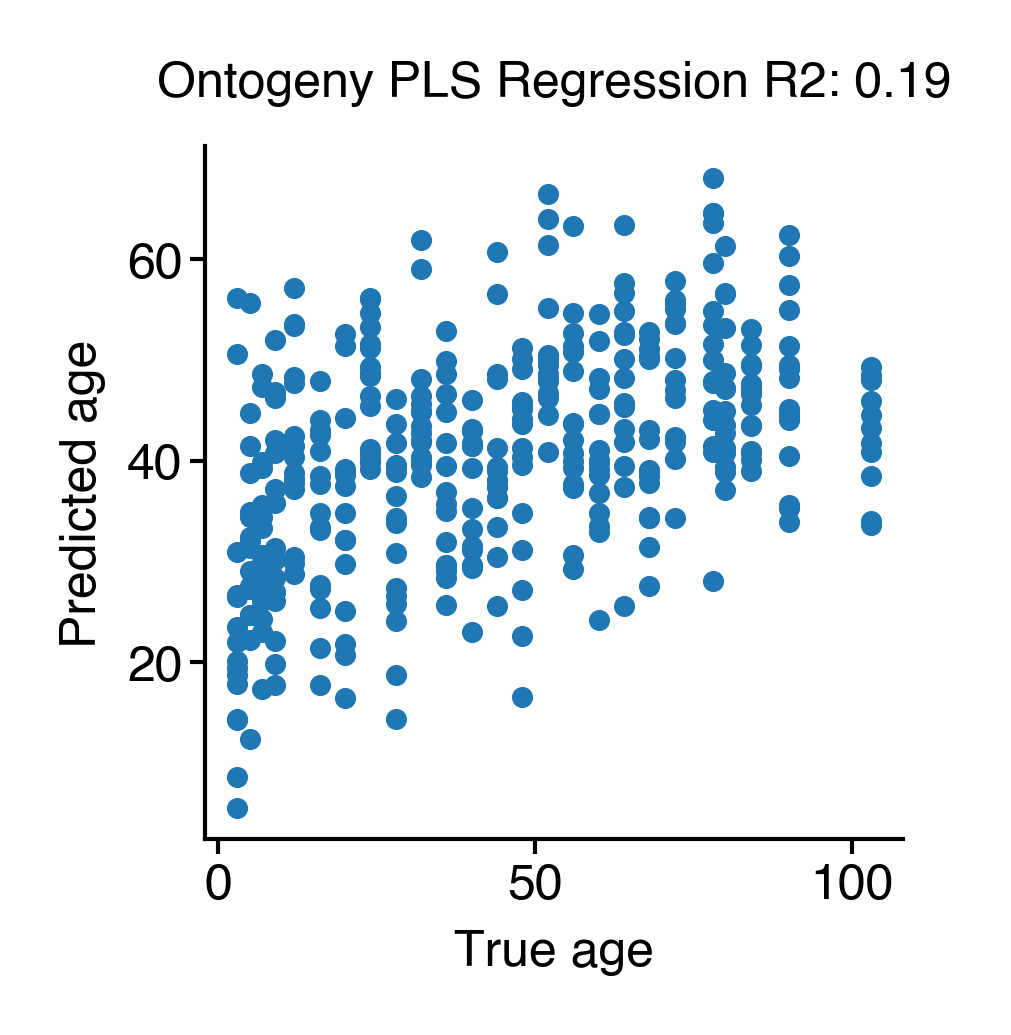

In [40]:
fig = figure(1.5, 1.5)
ax = fig.gca()
ax.scatter(y, test_pred, s=3)
ax.set(
    xlabel="True age",
    ylabel="Predicted age",
    title=f"Ontogeny PLS Regression R2: {r2:0.2f}",
)
sns.despine()